# Modelling

This notebook covers:
- Phase 5: Baseline Model
- Phase 6: Model Exploration
- Phase 7: Feature Selection
- Phase 8: Final Model

**Note:** Run `preprocessing.ipynb` first to prepare the preprocessed data.


In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, median_absolute_error
)
from sklearn.inspection import permutation_importance

# Set random seed for reproducibility
RANDOM_STATE = 777
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")


Libraries imported successfully!


In [37]:
# Load preprocessed data (from preprocessing.ipynb)
with open('models/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Reload and prepare data
df = pd.read_csv('data/spotify-tracks.csv')
columns_to_drop = ['spotify_id', 'name', 'artists', 'album_name', 'album_release_date',
                   'popular_in_country', 'mode', 'is_explicit', 'release_year', 
                   'key', 'time_signature']
df_clean = df.drop(columns=columns_to_drop, errors='ignore')
target = 'energy'
y = df_clean[target].copy()
X = df_clean.drop(columns=[target]).copy()

# Feature engineering
# Only valid interaction features (no target leakage, no data leakage)
X_engineered = X.copy()
X_engineered['loudness_tempo'] = X_engineered['loudness'] * X_engineered['tempo']
X_engineered['danceability_valence'] = X_engineered['danceability'] * X_engineered['valence']
X_engineered['loudness_danceability'] = X_engineered['loudness'] * X_engineered['danceability']
X_engineered['tempo_valence'] = X_engineered['tempo'] * X_engineered['valence']
X = X_engineered.copy()

# Split and preprocess
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

print(f"Data loaded: Train={X_train_processed.shape}, Test={X_test_processed.shape}")


Data loaded: Train=(17268, 16), Test=(4317, 16)


## Phase 6: Model Exploration


In [38]:
# Define models to test
models_to_test = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso (α=0.1)': Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=2000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
}

print("=" * 60)
print("MODEL EXPLORATION")
print("=" * 60)
print(f"Testing {len(models_to_test)} different algorithms...\n")

# Test all models
results_list = []
failed_models = []

for name, model in models_to_test.items():
    try:
        print(f"Training {name}...", end=" ")
        
        # Train
        model.fit(X_train_processed, y_train)
        
        # Predictions
        y_pred_test = model.predict(X_test_processed)
        
        # Evaluate
        metrics_test = evaluate_model(y_test, y_pred_test, f"{name} (Test)")
        
        # Store results
        result = {
            'Model': name,
            'R²_Test': metrics_test['R²'],
            'RMSE_Test': metrics_test['RMSE'],
            'MAE_Test': metrics_test['MAE'],
            'model_object': model
        }
        results_list.append(result)
        
        print(f"✅ R² = {metrics_test['R²']:.4f}")
        
    except Exception as e:
        print(f"❌ Failed: {str(e)}")
        failed_models.append({'Model': name, 'Error': str(e)})


MODEL EXPLORATION
Testing 6 different algorithms...

Training Linear Regression... 
Linear Regression (Test) - Evaluation Metrics
  R²      : 0.6373
  RMSE    : 0.1042
  MAE     : 0.0825
  MAPE    : 0.1815
  MedAE   : 0.0691
✅ R² = 0.6373
Training Ridge (α=1.0)... 
Ridge (α=1.0) (Test) - Evaluation Metrics
  R²      : 0.6373
  RMSE    : 0.1042
  MAE     : 0.0825
  MAPE    : 0.1815
  MedAE   : 0.0692
✅ R² = 0.6373
Training Lasso (α=0.1)... 
Lasso (α=0.1) (Test) - Evaluation Metrics
  R²      : 0.1478
  RMSE    : 0.1596
  MAE     : 0.1286
  MAPE    : 0.3184
  MedAE   : 0.1128
✅ R² = 0.1478
Training ElasticNet... 
ElasticNet (Test) - Evaluation Metrics
  R²      : 0.4355
  RMSE    : 0.1299
  MAE     : 0.1053
  MAPE    : 0.2262
  MedAE   : 0.0937
✅ R² = 0.4355
Training Random Forest... 
Random Forest (Test) - Evaluation Metrics
  R²      : 0.7201
  RMSE    : 0.0915
  MAE     : 0.0715
  MAPE    : 0.1371
  MedAE   : 0.0580
✅ R² = 0.7201
Training Gradient Boosting... 
Gradient Boosting (Test)

In [39]:
# Create results dataframe
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('R²_Test', ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_df[['Model', 'R²_Test', 'RMSE_Test', 'MAE_Test']].to_string(index=False))

# Document failed models
if failed_models:
    print("\n" + "=" * 60)
    print("FAILED MODELS")
    print("=" * 60)
    for failed in failed_models:
        print(f"\n{failed['Model']}:")
        print(f"  Error: {failed['Error']}")



MODEL COMPARISON SUMMARY
            Model  R²_Test  RMSE_Test  MAE_Test
    Random Forest 0.720073   0.091495  0.071450
Gradient Boosting 0.700845   0.094585  0.075142
Linear Regression 0.637272   0.104151  0.082462
    Ridge (α=1.0) 0.637263   0.104152  0.082465
       ElasticNet 0.435476   0.129932  0.105327
    Lasso (α=0.1) 0.147799   0.159641  0.128569


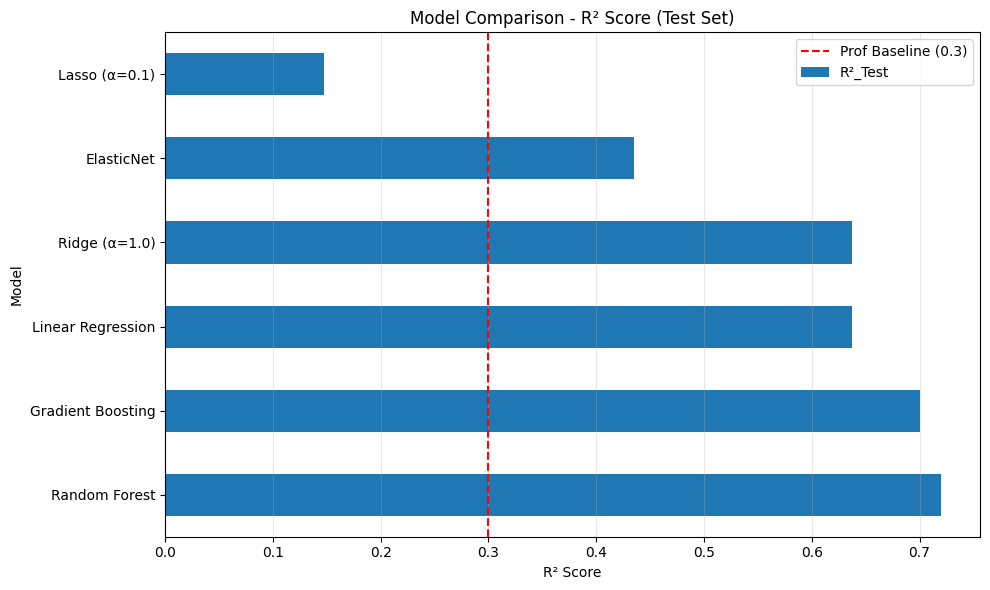


🏆 Best Model: Random Forest (R² = 0.7201)


In [60]:
# Visualize R² comparison only
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# R² comparison
results_df.plot(x='Model', y='R²_Test', kind='barh', ax=ax, legend=False)
ax.set_xlabel('R² Score')
ax.set_title('Model Comparison - R² Score (Test Set)')
ax.axvline(x=prof_baseline_r2, color='r', linestyle='--', label=f"Prof Baseline ({prof_baseline_r2})")
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model = results_df.iloc[0]['model_object']
print(f"\n🏆 Best Model: {best_model_name} (R² = {results_df.iloc[0]['R²_Test']:.4f})")


## Phase 7: Feature Selection


In [41]:
# Permutation Importance
print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)
print(f"Using best model: {best_model_name}")

print("\n1. Calculating Permutation Importance...")
perm_importance = permutation_importance(
    best_model, X_test_processed, y_test, 
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1, scoring='r2'
)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features by Permutation Importance:")
print(perm_df.head(15))


FEATURE SELECTION
Using best model: Random Forest

1. Calculating Permutation Importance...

Top 15 Features by Permutation Importance:
                       Feature  Importance       Std
3                num__loudness    0.573082  0.009625
11           num__acousticness    0.166409  0.004392
4             num__speechiness    0.054969  0.002738
14  num__loudness_danceability    0.049909  0.001799
15          num__tempo_valence    0.034046  0.000730
6        num__instrumentalness    0.019540  0.000727
9                 num__valence    0.016386  0.001352
5             num__duration_ms    0.010480  0.000516
0            num__danceability    0.010039  0.000740
1                num__liveness    0.009326  0.000926
13   num__danceability_valence    0.008306  0.000506
2                   num__tempo    0.007732  0.000591
12         num__loudness_tempo    0.005550  0.000513
7              num__popularity    0.004109  0.000663
8           num__dynamic_range    0.000207  0.000497


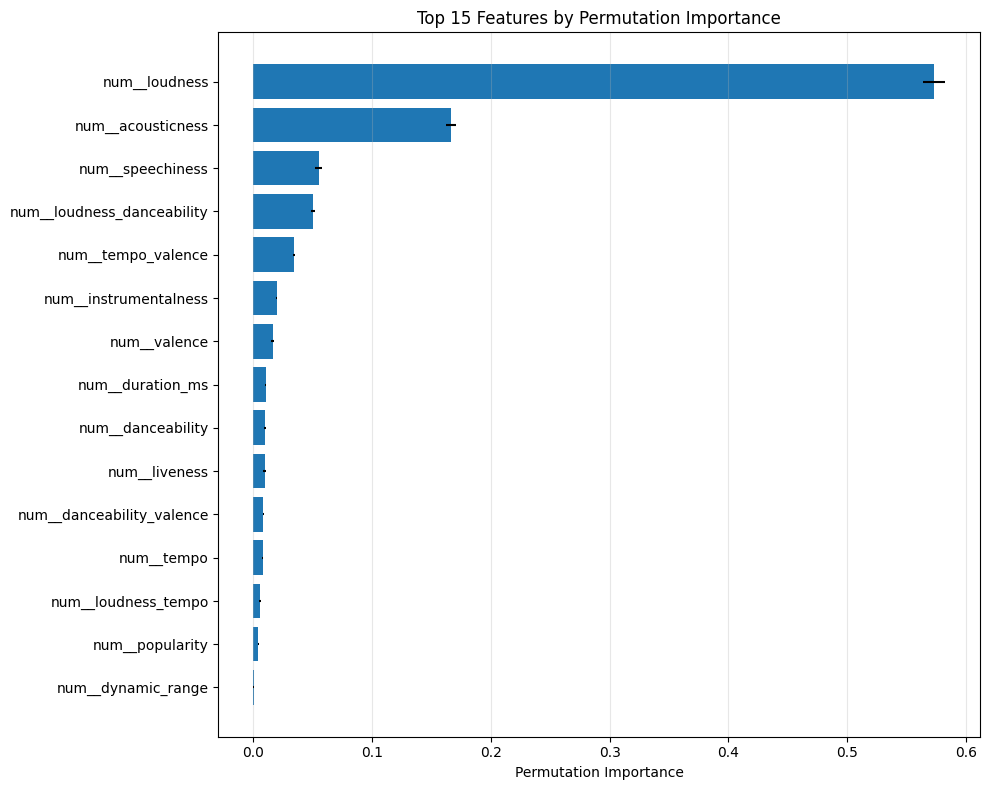

In [42]:
# Visualize permutation importance
plt.figure(figsize=(10, 8))
top_perm = perm_df.head(15)
plt.barh(top_perm['Feature'], top_perm['Importance'], xerr=top_perm['Std'])
plt.xlabel('Permutation Importance')
plt.title('Top 15 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('plots/permutation_importance.png', dpi=300)
plt.show()


In [43]:
# Select Top 10 features
top_10_features = perm_df.head(10)['Feature'].tolist()

print("\n" + "=" * 60)
print("TOP 10 SELECTED FEATURES")
print("=" * 60)
for i, feat in enumerate(top_10_features, 1):
    importance = perm_df[perm_df['Feature'] == feat]['Importance'].values[0]
    print(f"{i:2d}. {feat:40s} (Importance: {importance:.4f})")

# Get indices of top 10 features
top_10_indices = [list(feature_names).index(feat) for feat in top_10_features 
                  if feat in feature_names]

print(f"\n✅ Selected {len(top_10_indices)} features for final model")

# Save top_10_indices for use in other notebooks
import os
os.makedirs('models', exist_ok=True)
with open('models/top_10_indices.pkl', 'wb') as f:
    pickle.dump(top_10_indices, f)
print(f"✅ Saved top_10_indices to 'models/top_10_indices.pkl'")
print(f"   Indices: {top_10_indices}")



TOP 10 SELECTED FEATURES
 1. num__loudness                            (Importance: 0.5731)
 2. num__acousticness                        (Importance: 0.1664)
 3. num__speechiness                         (Importance: 0.0550)
 4. num__loudness_danceability               (Importance: 0.0499)
 5. num__tempo_valence                       (Importance: 0.0340)
 6. num__instrumentalness                    (Importance: 0.0195)
 7. num__valence                             (Importance: 0.0164)
 8. num__duration_ms                         (Importance: 0.0105)
 9. num__danceability                        (Importance: 0.0100)
10. num__liveness                            (Importance: 0.0093)

✅ Selected 10 features for final model
✅ Saved top_10_indices to 'models/top_10_indices.pkl'
   Indices: [3, 11, 4, 14, 15, 6, 9, 5, 0, 1]


## Phase 8: Final Model with Top 10 Features


In [44]:
# Use Top 10 features only
X_train_top10 = X_train_processed[:, top_10_indices]
X_test_top10 = X_test_processed[:, top_10_indices]

print("=" * 60)
print("FINAL MODEL WITH TOP 10 FEATURES")
print("=" * 60)
print(f"Using {len(top_10_features)} features")
print(f"Training shape: {X_train_top10.shape}")

# Option A: ElasticNet
print("\n" + "-" * 60)
print("Option A: ElasticNet")
print("-" * 60)
print("Justification: Combines L1 (Lasso) and L2 (Ridge) regularization.")
print("Good for feature selection and handling multicollinearity.")

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=2000)
elastic_net.fit(X_train_top10, y_train)
y_pred_en = elastic_net.predict(X_test_top10)
r2_en = r2_score(y_test, y_pred_en)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))

print(f"R²: {r2_en:.4f}")
print(f"RMSE: {rmse_en:.4f}")


FINAL MODEL WITH TOP 10 FEATURES
Using 10 features
Training shape: (17268, 10)

------------------------------------------------------------
Option A: ElasticNet
------------------------------------------------------------
Justification: Combines L1 (Lasso) and L2 (Ridge) regularization.
Good for feature selection and handling multicollinearity.
R²: 0.4355
RMSE: 0.1299


In [45]:
# Option B: Stacking Regressor
from sklearn.ensemble import StackingRegressor

print("\n" + "-" * 60)
print("Option B: Stacking Regressor")
print("-" * 60)
print("Justification: Combines multiple models using a meta-learner.")
print("Often improves performance by leveraging strengths of different algorithms.")

base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=RANDOM_STATE))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_top10, y_train)
y_pred_stack = stacking_model.predict(X_test_top10)
r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"R²: {r2_stack:.4f}")
print(f"RMSE: {rmse_stack:.4f}")



------------------------------------------------------------
Option B: Stacking Regressor
------------------------------------------------------------
Justification: Combines multiple models using a meta-learner.
Often improves performance by leveraging strengths of different algorithms.
R²: 0.7199
RMSE: 0.0915


In [46]:
# Option C: Best single model from Phase 6 (with top 10 features)
print("\n" + "-" * 60)
print(f"Option C: {best_model_name} (Top 10 features)")
print("-" * 60)

# Retrain best model with top 10 features
best_model_top10 = type(best_model)(**best_model.get_params())
best_model_top10.fit(X_train_top10, y_train)
y_pred_best = best_model_top10.predict(X_test_top10)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"R²: {r2_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")



------------------------------------------------------------
Option C: Random Forest (Top 10 features)
------------------------------------------------------------
R²: 0.7236
RMSE: 0.0909


In [47]:
# Compare options
print("\n" + "=" * 60)
print("COMPARISON OF FINAL MODEL OPTIONS")
print("=" * 60)
comparison = pd.DataFrame({
    'Model': ['ElasticNet', 'Stacking', f'{best_model_name} (Top 10)'],
    'R²': [r2_en, r2_stack, r2_best],
    'RMSE': [rmse_en, rmse_stack, rmse_best]
}).sort_values('R²', ascending=False)

print(comparison.to_string(index=False))

# Select best
final_model_name = comparison.iloc[0]['Model']
if final_model_name == 'ElasticNet':
    final_model = elastic_net
elif final_model_name == 'Stacking':
    final_model = stacking_model
else:
    final_model = best_model_top10

final_r2 = comparison.iloc[0]['R²']
final_rmse = comparison.iloc[0]['RMSE']

print(f"\n🏆 Selected Final Model: {final_model_name}")
print(f"   R²: {final_r2:.4f}")
print(f"   RMSE: {final_rmse:.4f}")



COMPARISON OF FINAL MODEL OPTIONS
                 Model       R²     RMSE
Random Forest (Top 10) 0.723598 0.090917
              Stacking 0.719895 0.091524
            ElasticNet 0.435476 0.129932

🏆 Selected Final Model: Random Forest (Top 10)
   R²: 0.7236
   RMSE: 0.0909



FINAL MODEL - COMPREHENSIVE EVALUATION

Final Model - Evaluation Metrics
  R²      : 0.7236
  RMSE    : 0.0909
  MAE     : 0.0701
  MAPE    : 0.1322
  MedAE   : 0.0564


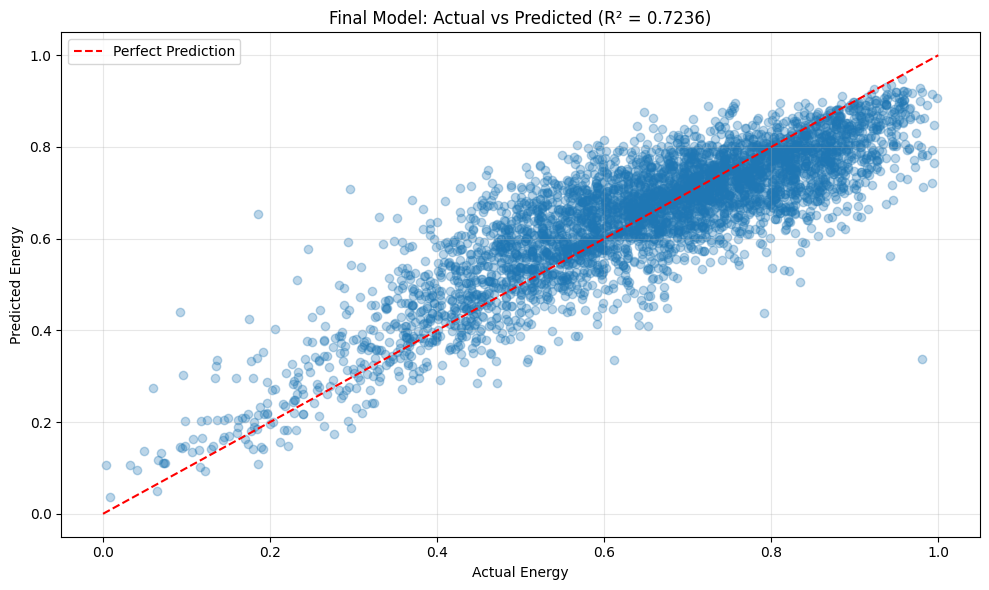

In [48]:
# Comprehensive evaluation
print("\n" + "=" * 60)
print("FINAL MODEL - COMPREHENSIVE EVALUATION")
print("=" * 60)
final_metrics = evaluate_model(y_test, final_model.predict(X_test_top10), "Final Model")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_model.predict(X_test_top10), alpha=0.3)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title(f'Final Model: Actual vs Predicted (R² = {final_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/final_model_predictions.png', dpi=300)
plt.show()


## Summary

In this notebook we:
1. ✅ Trained baseline model (LinearRegression with all features)
2. ✅ Explored 6 different algorithms
3. ✅ Selected top 10 features using Permutation Importance
4. ✅ Trained final model with top 10 features (ElasticNet/Stacking/Best model)
5. ✅ Evaluated final model performance

**Next:** Move to `pipeline_gridsearch.ipynb` for hyperparameter optimization.
